In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg
plt.style.use('dark_background')

In [114]:
h = 0.02
lx, ly = 1, 1
nx, ny = int(np.round(lx/h)), int(np.round(ly/h))
hx, hy = lx/nx, ly/ny
x = np.linspace(0.5*hx, lx-0.5*hx, nx)
y = np.linspace(0.5*hy, ly-0.5*hy, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

In [121]:
# def RHS(X, Y, s=7):
#     res = np.zeros_like(X)
#     for i in range(0, nx, s+1):
#         for j in range(0, ny, s+1):
#             if ((i//(s+1))+(j//(s+1)))%2 == 0:
#                 res[i, j] = 1
#             else:
#                 res[i, j] = -1
#     return res

def RHS(X, Y):
    res = np.zeros_like(X)
    c1 = (0.25, 0.25)
    c2 = (0.75, 0.25)
    c3 = (0.25, 0.75)
    c4 = (0.75, 0.75)
    r1 = 0.3
    r2 = 0.1
    r3 = 0.1
    r4 = 0.3
    res[((X-c1[0])**2+(Y-c1[1])**2) <= r1**2] = 1
    res[((X-c2[0])**2+(Y-c2[1])**2) <= r2**2] = -1
    res[((X-c3[0])**2+(Y-c3[1])**2) <= r3**2] = -1
    res[((X-c4[0])**2+(Y-c4[1])**2) <= r4**2] = 1
    return res




def OpL(u, hx, hy):
    res = np.zeros_like(u)
    res[1:, :] += (u[1:, :]-u[:-1, :])/hx**2
    res[:-1, :] += (u[:-1, :]-u[1:, :])/hx**2
    res[:, 1:] += (u[:, 1:]-u[:, :-1])/hy**2
    res[:, :-1] += (u[:, :-1]-u[:, 1:])/hy**2
    res[0, :] += (u[0, :]-u[-1, :])/hx**2
    res[-1, :] += (u[-1, :]-u[0, :])/hx**2
    res[:, 0] += (u[:, 0]-u[:, -1])/hy**2
    res[:, -1] += (u[:, -1]-u[:, 0])/hy**2
    res += u
    return res

def OpL_D(u, hx, hy):
    res = np.zeros_like(u)
    res[1:, :] += -u[:-1, :]/hx**2
    res[:-1, :] += -u[1:, :]/hx**2
    res[:, 1:] += -u[:, :-1]/hy**2
    res[:, :-1] += -u[:, 1:]/hy**2
    res[0, :] += -u[-1, :]/hx**2
    res[-1, :] += -u[0, :]/hx**2
    res[:, 0] += -u[:, -1]/hy**2
    res[:, -1] += -u[:, 0]/hy**2
    return res

def D(hx, hy):
    res = np.zeros_like(X)
    res += 2/hx**2
    res += 2/hy**2
    res += 1
    return res

def OpL_LIL(hx, hy, nx, ny):
    k = np.arange(nx*ny, dtype=int).reshape((nx, ny)) 
    L = sp.lil_matrix((nx*ny, nx*ny))
    for i in range(nx):
        for j in range(ny):
            L[k[i, j], k[i, j]] += 2.0/hy**2+2.0/hx**2+1
            L[k[i, j], k[i, (j-1)%ny]] = -1.0/hy**2
            L[k[i, j], k[i, (j+1)%ny]] = -1.0/hy**2
            L[k[i, j], k[(i-1)%nx, j]] = -1.0/hx**2
            L[k[i, j], k[(i+1)%nx, j]] = -1.0/hx**2
    return L.tocsr()

In [122]:
u1 = np.zeros_like(X)
F = RHS(X, Y)
r = OpL(u1, hx, hy)-F
while np.abs(np.sum(r**2) > 1e-5):
    Lr = OpL(r, hx, hy)
    Lu = OpL(u1, hx, hy)
    u1 += np.sum(Lr*r)/np.linalg.norm(Lr)**2*(F-Lu)
    r = Lu-F

In [123]:
u2 = np.zeros_like(X)
u02 = u2+1e-5
d = 1/D(hx, hy)
while np.sum(np.abs(u2-u02)) > 1e-10:
    u02 = u2.copy()
    u2 = (F-OpL_D(u2, hx, hy)) / D

In [118]:
L = OpL_LIL(hx, hy, nx, ny)
Ff = F.flatten()
u3 = linalg.spsolve(L, Ff).reshape((nx, ny))

In [119]:
ex1, ey1 = np.gradient(u1)
ex2, ey2 = np.gradient(u2)
ex3, ey3 = np.gradient(u3)
ex1, ey1, ex2, ey2, ex3, ey3 = -ex1, -ey1, -ex2, -ey2, -ex3, -ey3

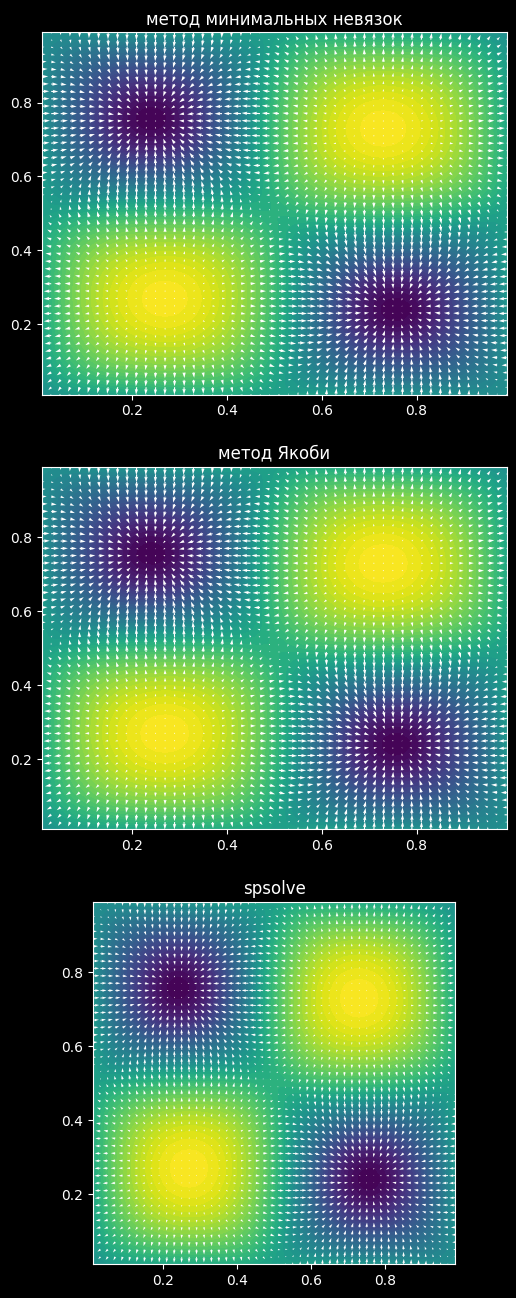

In [120]:
fig, ax = plt.subplots(3, 1, figsize=(6, 16))
ax[0].contourf(X, Y, u1, levels=50)
ax[0].quiver(X, Y, ex1, ey1, color='w')
ax[0].set_title('метод минимальных невязок')
ax[1].contourf(X, Y, u2, levels=50)
ax[1].quiver(X, Y, ex2, ey2, color='w')
ax[1].set_title('метод Якоби')
ax[2].contourf(X, Y, u3, levels=50)
ax[2].quiver(X, Y, ex3, ey3, color='w')
ax[2].set_title('spsolve');
ax[2].set_aspect('equal');

In [103]:
np.sum(np.array([1, 2, 3]))

6

In [104]:
np.array([1, 2, 3]).sum()

6